In [216]:
import time
import numpy as np
import matplotlib as mpl
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.utils import shuffle

In [217]:
def plot_misclassiﬁeds_per_iter(clf):
    plt.plot(range(1, len(clf.misclassifieds) + 1), clf.misclassifieds, marker='.')
    plt.title("Number of misclassiﬁed samples per iteration")
    plt.xlabel("Iterations")
    plt.ylabel("Number of misclassiﬁed samples")
    plt.show()

def print_accuracy(clf, train_X, train_y, test_X, test_y):
    print(f"train accuracy score: {np.sum(train_y == clf.predict(train_X)) / len(train_y)}")
    print(f"test accuracy score: {np.sum(test_y == clf.predict(test_X)) / len(test_y)}")
    
def print_confusion_matrix1(clf, test_X, test_y):    
    predicts = clf.predict(test_X)
    test_confusion_matrix = [[0 for i in range(2)] for j in range(2)]
    for i in range(len(test_y)):
        t = test_y[i]
        if t == predicts[i]:
            c = int(np.where(t == -1, 0, 1))
            test_confusion_matrix[c][c] += 1
        else:
            c = int(np.where(t == -1, 0, 1))
            p = int(np.where(predicts[i] == -1, 0, 1))
            test_confusion_matrix[c][p] += 1
    df = pd.DataFrame(test_confusion_matrix, columns=['Predict 0', 'Predict 1'], 
                      index=['Class 0', 'Class 1'])
    print("Confusion Matrix on test data:\n")
    print(df)

def show_result1(clf, train_X, train_y, test_X, test_y):
    plot_misclassiﬁeds_per_iter(clf)
    print_accuracy(clf, train_X, train_y, test_X, test_y)
    print()
    print_confusion_matrix1(clf, test_X, test_y)
    print("\n_______________________\n\n")

In [218]:
class Perceptron(object):
    def __init__(self, learning_rate=0.01, maxiter=100, random_state=1):
        self.learning_rate = learning_rate
        self.n_iter = maxiter
        self.random_state = random_state
        
    def fit(self, X, y):
        rand = np.random.RandomState(self.random_state)
        self.w = np.zeros(1 +  X.shape[1])
        self.misclassifieds = []
        
        for _ in range(self.n_iter):
            errors = 0
            for x, target in zip(X, y):
                update = self.learning_rate * (target - self.predict(x)) / 2 
                self.w[1:] += update * x
                self.w[0] += update
                errors += int(update != 0.0)
            self.misclassifieds.append(errors)
        return self
    
    def net_input(self, X):
        z = np.dot(X, self.w[1:]) + self.w[0]
        return z
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0, 1, -1)

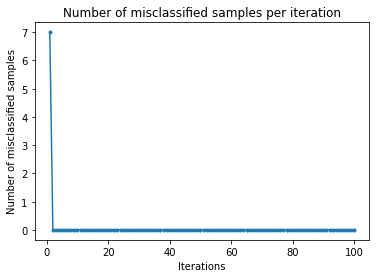

train accuracy score: 1.0
test accuracy score: 1.0

Confusion Matrix on test data:

         Predict 0  Predict 1
Class 0          9          0
Class 1          0         11

_______________________




In [219]:
# Q1
all_X, all_y = load_iris(return_X_y=True)
X, y = [], []
for i in range(len(all_y)):
    if all_y[i] == 0 or all_y[i] == 1:
        X.append(all_X[i])
        y.append(int(np.where(all_y[i] == 0, -1, 1)))
X, y = np.array(X), np.array(y)

X, y = shuffle(X, y)

train_X, test_X =  X[:int(0.8*len(X))], X[int(0.8*len(X)):]
train_y, test_y =  y[:int(0.8*len(y))], y[int(0.8*len(y)):]

per_clf = Perceptron(learning_rate=0.1, maxiter=100, random_state=1)
per_clf.fit(train_X, train_y)

show_result1(per_clf, train_X, train_y, test_X, test_y)

In [220]:
def generate_phi(x_set):
    linear_phi = [[1] + [x_set.iloc[i, j] for j in range(len(x_set.columns))] for i in range(len(x_set))] 
    return np.array(linear_phi)


def calcPhi(X):
    N = len(X)
    if len(np.shape(X)) == 1:
        d = 1
    else:
        d = np.shape(X)[1]
    Phi = np.zeros((N,d+1))
    Phi[:,0] = np.ones(N)
    Phi[:,1:] = np.reshape(X, (N,d))
    return Phi

def calcT(y, C):
    N = len(y)
    T = np.zeros((N, C))
    for c in range(C):
        T[:, c] = (y == c)
    return T

def calcP(W, Phi):
    P = np.exp( Phi @ (W.T) )
    P = P/np.reshape( np.sum(P, axis= 1), (len(Phi),1)  ) 
    return P

In [221]:
def cost_function(Wvec, Phi, T, lam):
    N, M = np.shape(Phi)
    C = np.shape(T)[1]
    W = np.reshape(Wvec, (C, M))
    P = calcP(W, Phi)
    J = -1.0/N*np.sum(T*np.log(P)) + lam/(2.0*N)*np.linalg.norm(Wvec)**2
    return J

def grad_cost_function(Wvec, Phi, T, lam):
    N, M = np.shape(Phi)
    C = np.shape(T)[1]
    W = np.reshape(Wvec, (C, M))
    P = calcP(W, Phi)
    grad_mat = 1.0/N*((P - T).T) @ Phi + lam/N*W
    grad_vec = np.reshape(grad_mat, len(Wvec))
    return grad_vec

def minimize_GD(errorFunc, w0, grad, learning_rate=0.01, maxiter=1e4, threshold=1e-5):
    w = w0
    iteration = 0
    loss_per_iter = [errorFunc(w0)]
    while iteration < maxiter:
        wold = w
        w = w - learning_rate*grad(w)
        iteration += 1
        loss_per_iter.append(errorFunc(w))
        if abs(errorFunc(w) - errorFunc(wold)) < threshold:
            break
    success = (iteration < maxiter)
    return {'w': w, 'iteration':iteration, 'error':errorFunc(w), 'success':success, 'loss_per_iter':loss_per_iter}

In [222]:
class LogisticClassifier:
    def __init__(self, C, lam):
        self.C = C  # the number of labels
        self.lam = lam # regularization parameter
        self.W = None
        self.loss_per_iter = None  
      
    # Train Logistic Regression useing Gradient Dessent
    def fit(self, X, y, method='NR', learning_rate=0.01, maxiter=1e4, threshold=1e-5, show_message=False):
        Phi = calcPhi(X)
        T = calcT(y, self.C)
        N, M = np.shape(Phi)
        
        w0 = np.zeros(M*self.C)
        time_start = time.time()
        result = minimize_GD(errorFunc=lambda w : cost_function(w, Phi, T, self.lam), 
                          w0=w0, 
                          grad=lambda w : grad_cost_function(w, Phi, T, self.lam),
                          learning_rate=learning_rate,
                          maxiter=maxiter,
                          threshold=threshold
                         )
        time_end = time.time()
        if show_message:
            print(f"success : {result['success']}")
            print(f"iteration : {result['iteration']}")
            print(f"calcualtion time : {time_end - time_start} seconds")
        self.W = np.reshape(result['w'], (self.C, M))
        self.loss_per_iter = result['loss_per_iter']
        
        return result
        
    def predict_proba(self, X):
        return calcP(self.W, calcPhi(X))
        
    def predict(self, X):
        tmp = self.predict_proba(X)
        return np.argmax(tmp, axis=1)

In [223]:
Iris_dataset = load_iris()

X, y = load_iris(return_X_y=True)
X, y = shuffle(X, y)

train_X, test_X =  X[:int(0.8*len(X))], X[int(0.8*len(X)):]
train_y, test_y =  y[:int(0.8*len(y))], y[int(0.8*len(y)):]

print(f"Training data : {len(train_X)}")
print(f"Test data : {len(test_X)}")
print(f"Input dimension : {train_X.shape[1]}")

Training data : 120
Test data : 30
Input dimension : 4


In [224]:
def plot_loss_per_iter(clf):
    plt.plot(range(1, len(clf.loss_per_iter) + 1), clf.loss_per_iter)
    plt.title("Loss Value per Iteration for train dataset")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

def print_accuracy(clf, train_X, train_y, test_X, test_y):
    print(f"train accuracy score: {np.sum(train_y == clf.predict(train_X)) / len(train_y)}")
    print(f"test accuracy score: {np.sum(test_y == clf.predict(test_X)) / len(test_y)}")
    
def print_confusion_matrix(clf, test_X, test_y):
    predicts = clf.predict(test_X)
    test_confusion_matrix = [[0 for i in range(3)] for j in range(3)]
    for i in range(len(test_y)):
        t = test_y[i]
        if t == predicts[i]:
            test_confusion_matrix[t][t] += 1
        else:
            test_confusion_matrix[t][predicts[i]] += 1
    df = pd.DataFrame(test_confusion_matrix, columns=['Predict ' + str(i) for i in range(3)], 
                      index=['Class ' + str(i) for i in range(3)])
    print("Confusion Matrix on test data:\n")
    print(df)

def show_result(clf, train_X, train_y, test_X, test_y):
    plot_loss_per_iter(clf)
    print_accuracy(clf, train_X, train_y, test_X, test_y)
    print()
    print_confusion_matrix(clf, test_X, test_y)
    print("\n_______________________\n\n")

success : True
iteration : 7030
calcualtion time : 1.2516896724700928 seconds


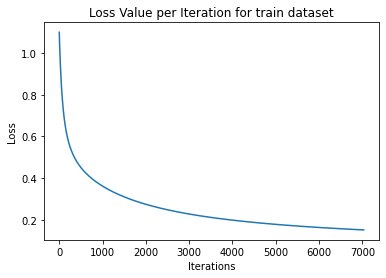

train accuracy score: 0.9833333333333333
test accuracy score: 0.9666666666666667

Confusion Matrix on test data:

         Predict 0  Predict 1  Predict 2
Class 0         10          0          0
Class 1          0          9          0
Class 2          0          1         10

_______________________




In [225]:
# Q2.a
clf = LogisticClassifier(C=3, lam=0)
clf.fit(train_X, train_y, show_message=True)
show_result(clf, train_X, train_y, test_X, test_y)


--> lambda = 0.1
success : True
iteration : 6370
calcualtion time : 1.1140518188476562 seconds


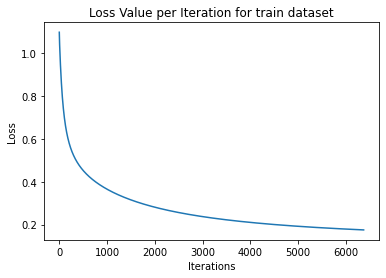

train accuracy score: 0.9833333333333333
test accuracy score: 1.0

Confusion Matrix on test data:

         Predict 0  Predict 1  Predict 2
Class 0         10          0          0
Class 1          0          9          0
Class 2          0          0         11

_______________________


--> lambda = 1.0
success : True
iteration : 3901
calcualtion time : 0.6821780204772949 seconds


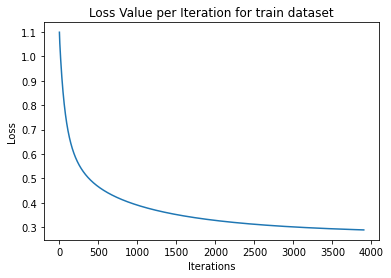

train accuracy score: 0.975
test accuracy score: 1.0

Confusion Matrix on test data:

         Predict 0  Predict 1  Predict 2
Class 0         10          0          0
Class 1          0          9          0
Class 2          0          0         11

_______________________


--> lambda = 10.0
success : True
iteration : 1052
calcualtion time : 0.1934797763824463 seconds


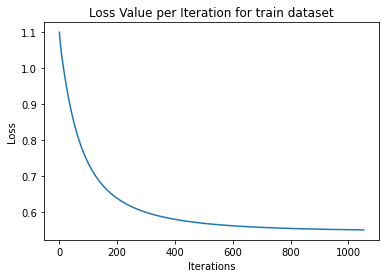

train accuracy score: 0.9666666666666667
test accuracy score: 0.9666666666666667

Confusion Matrix on test data:

         Predict 0  Predict 1  Predict 2
Class 0         10          0          0
Class 1          0          8          1
Class 2          0          0         11

_______________________




In [226]:
# Q2.b
lams = [0.1, 1.0, 10.0]

for lam in lams:
    print(f"--> lambda = {lam}")
    clf = LogisticClassifier(C=3, lam=lam)
    clf.fit(train_X, train_y, show_message=True)
    show_result(clf, train_X, train_y, test_X, test_y)